# EG39 CITE-seq and flow cytometry comparisons

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scvi
import scanpy as sc
from ridgeplot import ridgeplot

import sklearn.mixture

import warnings

warnings.filterwarnings('ignore')

Global seed set to 0
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


Sample used in this notebook is EG39. 

### Sample information:
- MDS
- diagnosis
- 11% of bonemarrow cells are blasts


## Preparing files

In [2]:
#raw protein data, all datasets, raw + CLR and DSB normalized

adata = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_easi_norm.h5ad')

adata.shape

(121340, 8051)

In [3]:
#select sample
adata_sample=adata[adata.obs['eg_code'] == 'EG39']

In [4]:
#selecting only leukemic cells

eg_blasts=adata_sample[adata_sample.obs['new_cell_type'] == 'leukemic']

eg_blasts.obs['new_cell_type']

Series([], Name: new_cell_type, dtype: category
Categories (0, object): [])

In [5]:
#select CLR normalized protein counts (only leukemic cells)

prot_clr=eg_blasts.obsm['protein_expression_clr']

prot_clr

,CD19,CD10,CD20,CD3,CD2,CD11b,HLADR,CD38,CD11c,CD7,...,CD5,CD15,CD64,CD117,CD24,CD44,CD58,CD66ace,CD13,CD34


In [6]:
#select DSB normalized protein counts

prot_dsb=eg_blasts.obsm['protein_expression_dsb']

prot_dsb

,CD19,CD10,CD20,CD3,CD2,CD11b,HLADR,CD38,CD11c,CD7,...,CD5,CD15,CD64,CD117,CD24,CD44,CD58,CD66ace,CD13,CD34


In [7]:
#convert excel to csv (flow data)

#read_file = pd.read_excel (r'/Users/tiinatuononen/Desktop/Thesis/Project/data/flow.xlsx')
#read_file.to_csv (r'/Users/tiinatuononen/Desktop/Thesis/Project/data/flow.csv', index = None, header=True)

In [8]:
#get flow data

flow= pd.read_csv('/Users/tiinatuononen/Desktop/Thesis/Project/data/flow.csv')

### Depending on used dataset, celltype annotations are varying (made by different groups). "new_cell_types" is made based on these, it is a "standardized" version of cell type annotations. 

In [9]:
#Cell types offered by new_cell_type

adata.obs['new_cell_type'].unique().tolist()

['NK',
 'non-leukemic',
 'preleukemic',
 'non-leukemic?',
 nan,
 'leukemic',
 'leukemic?',
 'doublets?',
 'unknown',
 '0',
 'preleukemic?']

In [10]:
#cell type annotations offered by cell_type

adata.obs['cell_type'].unique().tolist()

['NKT',
 'non-leukemic',
 'preleukemic',
 'non-leukemic?',
 nan,
 'leukemic',
 'leukemic?',
 'doublets?',
 'unknown',
 '0',
 'preleukemic?']

## CLR normalized



In [11]:
#CLR normalized, only leukemic cells

prot_clr

,CD19,CD10,CD20,CD3,CD2,CD11b,HLADR,CD38,CD11c,CD7,...,CD5,CD15,CD64,CD117,CD24,CD44,CD58,CD66ace,CD13,CD34


In [12]:
#flow results for selected sample

egflow=flow[flow['EG_code'] == 'EG39'].dropna(axis=1)

egflow

,EG_code,CD13,CD15,CD34,CD71,CD105,CD123,CD133
17,EG39,1.0,0.05,1.0,1.0,1.0,1.0,0.57


In [13]:
#drop EG_code

egflow=egflow.drop("EG_code", axis=1)

egflow

,CD13,CD15,CD34,CD71,CD105,CD123,CD133
17,1.0,0.05,1.0,1.0,1.0,1.0,0.57


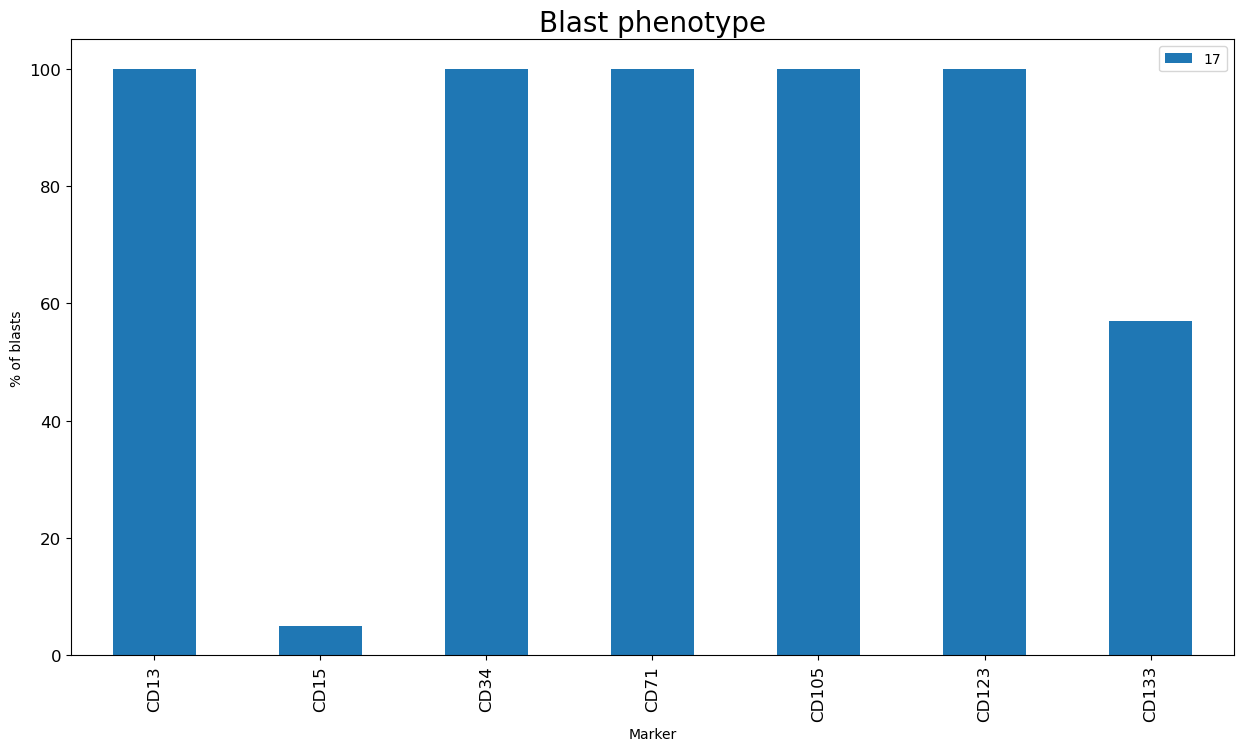

In [14]:
df=egflow * 100 #multiplied by 100 to get percentages

df1=df.T

df1.plot.bar(xlabel="Marker", ylabel="% of blasts",
            figsize= (15,8),
           fontsize="large") ;

plt.title('Blast phenotype', fontsize=20) ;

In [15]:
egflow=egflow*100

In [16]:
flow_markers=egflow.columns
flow_markers

Index(['CD13', 'CD15', 'CD34', 'CD71', 'CD105', 'CD123', 'CD133'], dtype='object')

In [17]:
#Selecting common markers between flow and cite-seq

listOfMarkers=flow_markers
column_names=list()    #list including the common markers

for x in listOfMarkers:
    if x in prot_clr.columns:
        print(x, "Yes")
        column_names.append(x)
    else:
        print(x, "No") 
        
print(column_names)

CD13 Yes
CD15 Yes
CD34 Yes
CD71 No
CD105 No
CD123 Yes
CD133 No
['CD13', 'CD15', 'CD34', 'CD123']


In [18]:
prot_clr.shape

(0, 33)

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 2 is required by GaussianMixture.

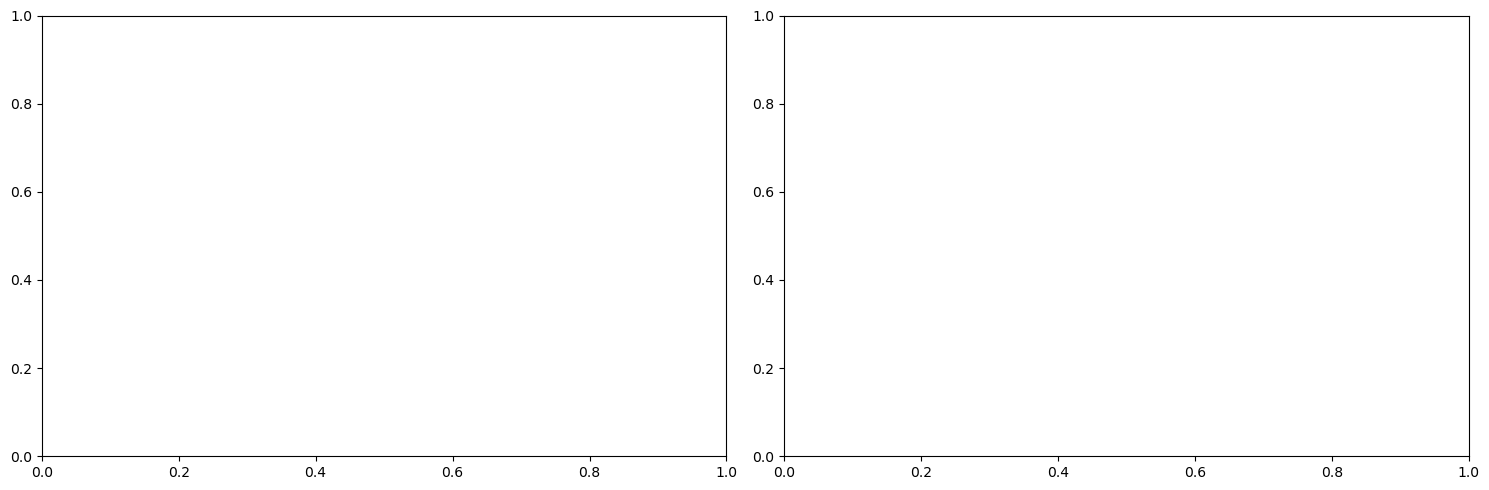

In [19]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "full",
                                      random_state = 42
                                        )
#data

data=prot_clr
n_cells=len(prot_clr)
egflow=egflow
for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(15, 5))
    fig.show()
    
    x= data[column_name]
    x=x.values.reshape(-1, 1)
    gmm.fit(x)
    labels = gmm.predict(x)
    
    x0 = data[column_name].reset_index(drop=True)[labels == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels == 1].mean()
    if x0 < x1:
        labels = (~(labels == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data, x=column_name, hue=labels, multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels==0)
    result_zeros=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels)
    result_ones=(n_ones/n_cells * 100)
    #Dataframes
    all_data = {"GMM":[result_ones],
        "Flow": egflow[column_name],
        };

    all_data= pd.DataFrame(data=all_data);
    
    ax2=all_data.plot.bar(rot=15, title=column_name,ax=ax[1]);
    ax2.title.set_text('Proportions')
    
    print("Percentage of positive cells, based on GMM:", result_ones)
    
    plt.show()

## DSB Normalized

In [ ]:
prot_dsb

In [ ]:
#Selecting common markers between flow and cite-seq

listOfMarkers=flow_markers
column_names=list()    #list including the common markers

for x in listOfMarkers:
    if x in prot_dsb.columns:
        print(x, "Yes")
        column_names.append(x)
    else:
        print(x, "No") 
        
print(column_names)

In [ ]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "full",
                                      random_state = 42
                                        )
#data

data_dsb=prot_dsb
n_cells=len(prot_dsb)
egflow=egflow 
for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(15, 5))
    fig.show()
    
    x2= data_dsb[column_name]
    x2=x2.values.reshape(-1, 1)
    gmm.fit(x2)
    labels2 = gmm.predict(x2)
    
    x0 = data[column_name].reset_index(drop=True)[labels2 == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels2 == 1].mean()
    if x0 < x1:
        labels2 = (~(labels2 == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data_dsb, x=column_name, hue=labels2, multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels2==0)
    result_zeros2=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels2)
    result_ones2=(n_ones/n_cells * 100)
    #Dataframes
    all_data2 = {"GMM":[result_ones2],
        "Flow": egflow[column_name],
        };

    all_data2= pd.DataFrame(data=all_data2);
    
    ax2=all_data2.plot.bar(rot=15, title=column_name,ax=ax[1]);
    ax2.title.set_text('Proportions')
    
    print("Percentage of positive cells:", result_ones2)
    
    plt.show()

In [ ]:
#Different covariance type used in the model

#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "spherical",
                                      random_state = 42
                                        )
#data

data_dsb=prot_dsb
n_cells=len(prot_dsb)
egflow=egflow
for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(15, 5))
    fig.show()
    
    x3= data_dsb[column_name]
    x3=x3.values.reshape(-1, 1)
    gmm.fit(x3)
    labels3 = gmm.predict(x3)
    
    x0 = data[column_name].reset_index(drop=True)[labels3 == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels3 == 1].mean()
    if x0 < x1:
        labels3 = (~(labels3 == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data_dsb, x=column_name, hue=labels3, multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels3==0)
    result_zeros3=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels3)
    result_ones3=(n_ones/n_cells * 100)
    #Dataframes
    all_data3 = {"GMM":[result_ones3],
        "Flow": egflow[column_name],
        };

    all_data3= pd.DataFrame(data=all_data3);
    
    ax2=all_data3.plot.bar(rot=15, title=column_name,ax=ax[1]);
    ax2.title.set_text('Proportions')
    
    print("Percentage of positive cells:", result_ones3)
    
    plt.show()

In [ ]:
#Different covariance type used in the model

#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "tied",
                                      random_state = 42
                                        )
#data

data_dsb=prot_dsb
n_cells=len(prot_dsb)
egflow=egflow
for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(15, 5))
    fig.show()
    
    x4= data_dsb[column_name]
    x4=x4.values.reshape(-1, 1)
    gmm.fit(x4)
    labels4 = gmm.predict(x4)
    
    ax1 = sns.kdeplot(data=data_dsb, x=column_name, hue=labels4, multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels4==0)
    result_zeros4=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels4)
    result_ones4=(n_ones/n_cells * 100)
    #Dataframes
    all_data4 = {"GMM":[result_ones4],
        "Flow": egflow[column_name],
        };

    all_data4= pd.DataFrame(data=all_data4);
    
    ax2=all_data4.plot.bar(rot=15, title=column_name,ax=ax[1]);
    ax2.title.set_text('Proportions')
    
    print("Percentage of positive cells:", result_ones4)
    
    plt.show()

In [ ]:
#Different covariance type used in the model

#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "diag",
                                      random_state = 42
                                        )
#data

data_dsb=prot_dsb
n_cells=len(prot_dsb)
egflow=egflow
for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(15, 5))
    fig.show()
    
    x5= data_dsb[column_name]
    x5=x5.values.reshape(-1, 1)
    gmm.fit(x5)
    labels5= gmm.predict(x5)
    
    x0 = data[column_name].reset_index(drop=True)[labels5 == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels5 == 1].mean()
    if x0 < x1:
        labels5 = (~(labels5 == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data_dsb, x=column_name, hue=labels5, multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels5==0)
    result_zeros5=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels5)
    result_ones5=(n_ones/n_cells * 100)
    #Dataframes
    all_data5 = {"GMM":[result_ones5],
        "Flow": egflow[column_name],
        };

    all_data5= pd.DataFrame(data=all_data5);
    
    ax2=all_data5.plot.bar(rot=15, title=column_name,ax=ax[1]);
    ax2.title.set_text('Proportions')
    
    print("Percentage of positive cells:", result_ones5)
    
    plt.show()

In [ ]:
labels_CLR

## Both normalization methods

In [ ]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "full",
                                      random_state = 42
                                        )


for column_name in column_names:
    fig, ax =plt.subplots(1,6,tight_layout=True, figsize=(15, 5))
    fig.show()
    
    #Original density plots
    ax1 = sns.kdeplot(data=prot_clr, x=column_name, multiple="stack", ax=ax[0]) ;
    ax2 = sns.kdeplot(data=prot_dsb, x=column_name, multiple="stack", color="g", ax=ax[1]) ;

    
    ax1.title.set_text('CLR')    #headings for subplots
    ax2.title.set_text('DSB')

    
    #CLR
    x_CLR= prot_clr[column_name]
    x_CLR=x_CLR.values.reshape(-1, 1)
    gmm.fit(x_CLR)
    labels_CLR = gmm.predict(x_CLR)
    labels_CLR = pd.Series(labels_CLR)
    
    x0 = prot_clr[column_name].reset_index(drop=True)[labels_CLR == 0].mean()
    x1 = prot_clr[column_name].reset_index(drop=True)[labels_CLR == 1].mean()
    if x0 < x1:
        labels_CLR = (~(labels_CLR == 1)).astype(int)
    
    #ax3 = sns.kdeplot(data=prot_clr, x=column_name, hue=labels_CLR, multiple="stack", ax=ax[2]) ;
    #ax3.title.set_text('CLR')   
    
    #DSB
    x_DSB = prot_dsb[column_name]
    x_DSB=x_DSB.values.reshape(-1, 1)
    gmm.fit(x_DSB)
    labels_DSB = gmm.predict(x_DSB)

    x0 = prot_dsb[column_name].reset_index(drop=True)[labels_DSB == 0].mean()
    x1 = prot_dsb[column_name].reset_index(drop=True)[labels_DSB == 1].mean()
    if x0 < x1:
        labels_DSB = (~(labels_DSB == 1)).astype(int)
    
    ax4 = sns.kdeplot(data=prot_dsb, x=column_name, hue=labels_DSB, multiple="stack", color="g", ax=ax[3]) ;
    
    ax4.title.set_text('DSB')

    #Calculate zeros
    n_zeros1 = np.count_nonzero(labels_CLR==0)
    n_zeros2 = np.count_nonzero(labels_DSB==0)
    result_zeros_CLR=(n_zeros1/n_cells * 100)
    result_zeros_DSB=(n_zeros2/n_cells * 100)
    #Calculate ones
    n_ones_CLR=np.count_nonzero(labels_CLR)
    n_ones_DSB=np.count_nonzero(labels_DSB)
    #percentages
    result_ones_CLR=(n_ones_CLR/n_cells * 100)
    result_ones_DSB=(n_ones_DSB/n_cells * 100)
    #Dataframes
    data_CLR = {"0s":[result_zeros_CLR],
        "1s":[result_ones_CLR]
        };

    dataFrame_CLR = pd.DataFrame(data=data_CLR)
    
    data_DSB = { "0s":[result_zeros_DSB],
        "1s":[result_ones_DSB]
        };
    dataFrame_DSB = pd.DataFrame(data=data_DSB)
    
    ax5= dataFrame_CLR.plot.bar(title=column_name, ax=ax[4]);
    ax6= dataFrame_DSB.plot.bar(title=column_name, ax=ax[5]);

    ax5.title.set_text('CLR')    #headings for subplots
    ax6.title.set_text('DSB')
    plt.show()

